# Setup Data....

In [1]:
!pip install scikit-learn===1.6.1
!pip install seaborn===0.13.2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import seaborn as sns

In [3]:
df = pd.read_csv('dataset/bank_transactions_data_2.csv', delimiter = ',')

df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['Hour of Transaction'] = df['TransactionDate'].dt.hour
df['TransactionDay'] = df['TransactionDate'].dt.date
df['DayOfWeek'] = df['TransactionDate'].dt.day_name()
df['Hour'] = df['TransactionDate'].dt.hour
df['PreviousTransactionDate'] = pd.to_datetime(df['PreviousTransactionDate'])
df['Time_Gap'] = (df['TransactionDate'] - df['PreviousTransactionDate'])

# In Minutes...
df['TimeGap'] = (df['TransactionDate'] - df['PreviousTransactionDate']).dt.total_seconds()/60
df['AgeGroup'] = pd.cut(df['CustomerAge'], bins=[0,25,35,50,100], labels=['18-25', '26-35', '36-50', '51+'])

print(df.columns)

Index(['TransactionID', 'AccountID', 'TransactionAmount', 'TransactionDate',
       'TransactionType', 'Location', 'DeviceID', 'IP Address', 'MerchantID',
       'Channel', 'CustomerAge', 'CustomerOccupation', 'TransactionDuration',
       'LoginAttempts', 'AccountBalance', 'PreviousTransactionDate',
       'Hour of Transaction', 'TransactionDay', 'DayOfWeek', 'Hour',
       'Time_Gap', 'TimeGap', 'AgeGroup'],
      dtype='object')


# K-means Clustering

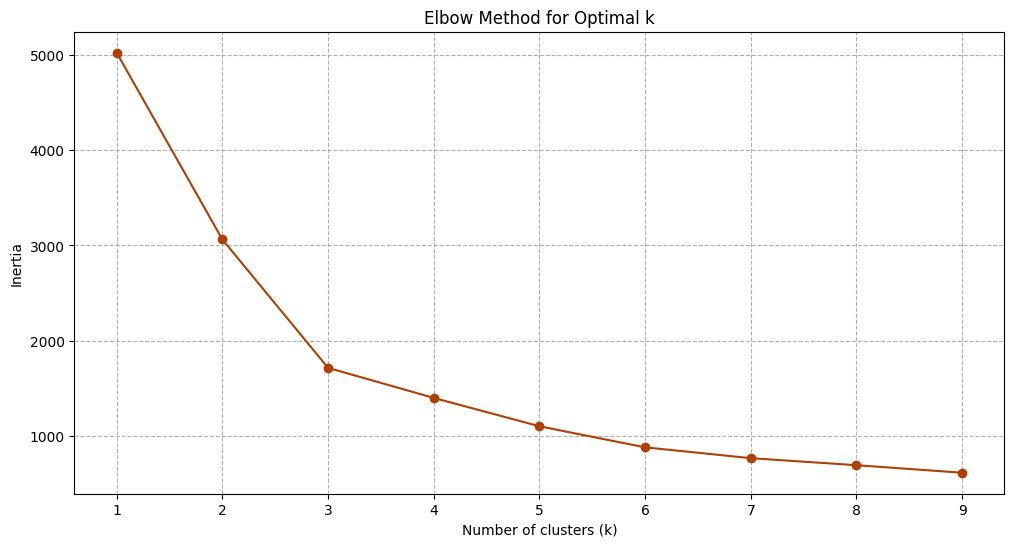

In [4]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# NOTE: Elbow technique to determine best K
features = ['CustomerAge', 'TransactionAmount'] 
X = df[features].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(12, 6))
plt.plot(K, inertia, marker='o', linestyle='-', color=sns.color_palette("YlOrBr", 10)[8])  
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True, linestyle='--')  
plt.show()

For the above plot, the elbow appears to be around 3.

Therefore, using 3 clusters for K-means clustering seems to be optimal.

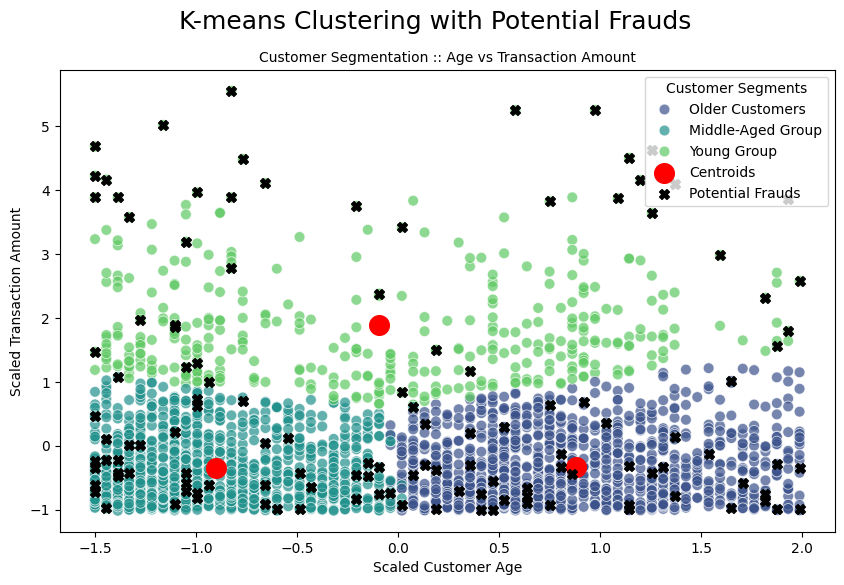

Segment Sizes: 
 Customer_Segment
0    1096
1    1032
2     384
Name: count, dtype: int64

Total number of potential frauds detected: 126

Cluster 0 Characteristics:
       CustomerAge  TransactionAmount  TransactionDuration
count  1096.000000        1096.000000          1096.000000
mean     60.344891         198.827892           117.841241
std       9.321729         152.556970            68.163277
min      44.000000           0.840000            10.000000
25%      53.000000          71.327500            63.000000
50%      59.000000         165.555000           111.000000
75%      67.250000         310.147500           161.000000
max      80.000000         651.550000           299.000000

Cluster 1 Characteristics:
       CustomerAge  TransactionAmount  TransactionDuration
count  1032.000000        1032.000000          1032.000000
mean     28.673450         197.253227           121.930233
std       7.336511         148.363520            73.091700
min      18.000000           0.260000  

In [5]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

CLUSTER_COUNT = 3

X = df[['CustomerAge', 'TransactionAmount', 'TransactionDuration']]  # You can include more features

# Scale the data to standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=CLUSTER_COUNT, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

df['Customer_Segment'] = kmeans_labels

distances = np.linalg.norm(X_scaled - kmeans.cluster_centers_[kmeans_labels], axis=1)

# Threshold: 5% furthest from centroid
threshold = np.percentile(distances, 95)
df['Potential_Fraud'] = distances > threshold

cluster_labels = {0: 'Older Customers', 1: 'Middle-Aged Group', 2: 'Young Group'}
custom_labels = [cluster_labels[label] for label in kmeans_labels]

plt.figure(figsize=(10, 6))

sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=custom_labels, palette='viridis', s=60, alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', label='Centroids')
plt.scatter(X_scaled[distances > threshold, 0], X_scaled[distances > threshold, 1], color='black', s=50, label='Potential Frauds', marker='X')

plt.suptitle('K-means Clustering with Potential Frauds', fontsize=18)
plt.title('Customer Segmentation :: Age vs Transaction Amount', fontsize=10)
plt.xlabel('Scaled Customer Age')
plt.ylabel('Scaled Transaction Amount')
plt.legend(title='Customer Segments', loc='upper right')
plt.show()

segment_sizes = df['Customer_Segment'].value_counts()
print("Segment Sizes: \n", segment_sizes)

frauds = df[df['Potential_Fraud']]
print(f"\nTotal number of potential frauds detected: {len(frauds)}")

for segment in range(CLUSTER_COUNT):
    print(f"\nCluster {segment} Characteristics:")
    print(df[df['Customer_Segment'] == segment][['CustomerAge', 'TransactionAmount', 'TransactionDuration']].describe())

print(f"\nFraudulent Transactions Statistics:")
print(frauds[['CustomerAge', 'TransactionAmount', 'TransactionDuration']].describe())

### K-means clustering conclusion

Fraudulent transactions usually have:
- Higher transaction amounts than average.
- Longer transaction durations.
- A broad age range, but tend to skew older (44.5 years on average).

# DBSCAN Clustering

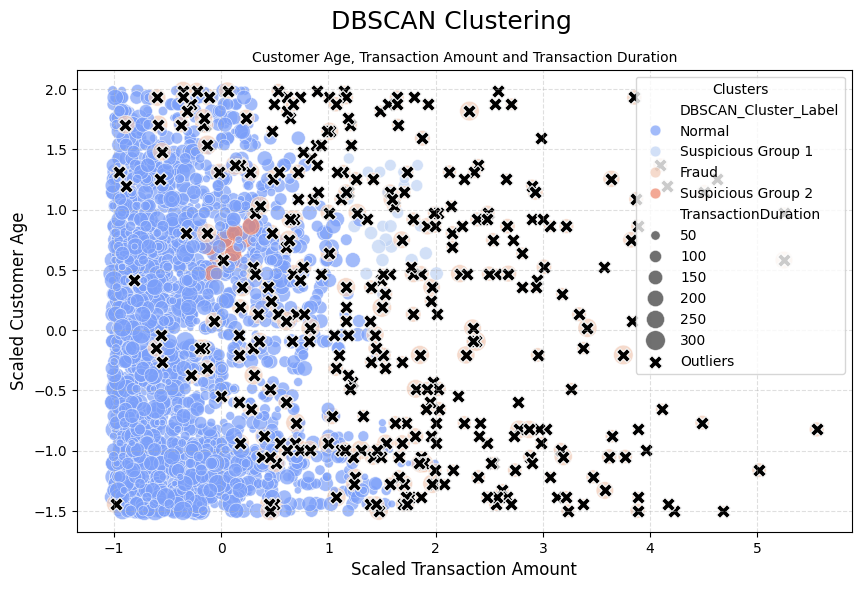

DBSCAN_Cluster_Label
Normal                2082
Fraud                  341
Suspicious Group 1      26
Suspicious Group 2      11
Name: count, dtype: int64


In [6]:
from sklearn.cluster import DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

X = df[['TransactionAmount', 'CustomerAge', 'TransactionDuration']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

dbscan = DBSCAN(eps=0.3, min_samples=5) 
dbscan_labels = dbscan.fit_predict(X_scaled)

label_mapping = {-1: 'Fraud', 0: 'Normal', 1: 'Suspicious Group 1', 2: 'Suspicious Group 2'}
df['DBSCAN_Cluster'] = dbscan_labels
df['DBSCAN_Cluster_Label'] = df['DBSCAN_Cluster'].map(label_mapping)

plt.figure(figsize=(10, 6))

sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=df['DBSCAN_Cluster_Label'], 
                palette='coolwarm', s=60, alpha=0.7, marker='o', 
                size=df['TransactionDuration'], sizes=(20, 200))

sns.scatterplot(x=X_scaled[df['DBSCAN_Cluster'] == -1, 0], 
                y=X_scaled[df['DBSCAN_Cluster'] == -1, 1], 
                color='black', s=100, label='Outliers', marker='X')

plt.suptitle('DBSCAN Clustering', fontsize=18)
plt.title('Customer Age, Transaction Amount and Transaction Duration', fontsize=10)
plt.xlabel('Scaled Transaction Amount', fontsize=12)
plt.ylabel('Scaled Customer Age', fontsize=12)
plt.legend(title='Clusters', loc='upper right')
plt.grid(True, linestyle='--', alpha=0.4)  

plt.show()
print(df['DBSCAN_Cluster_Label'].value_counts())

**NOTE**: The bigger the point, the longer the transaction time.

For better visualization, below is a plot of correlation between transaction duration and fraud detection.

Fraud Transaction Duration Statistics:
count    341.000000
mean     154.826979
std       82.619126
min       10.000000
25%       84.000000
50%      151.000000
75%      229.000000
max      300.000000
Name: TransactionDuration, dtype: float64

Non-Fraud Transaction Duration Statistics:
count    2171.000000
mean      114.116997
std        66.102582
min        10.000000
25%        61.000000
50%       108.000000
75%       156.000000
max       300.000000
Name: TransactionDuration, dtype: float64


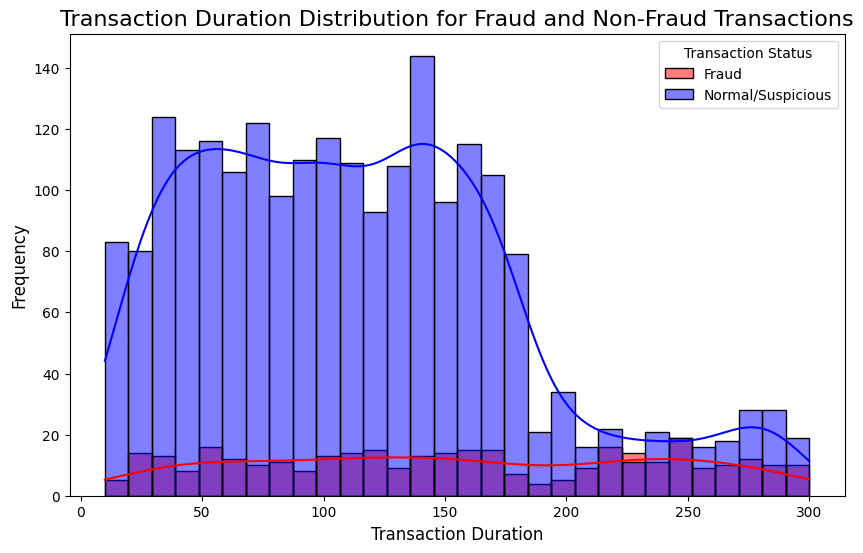

In [7]:
fraud_transactions = df[df['DBSCAN_Cluster_Label'] == 'Fraud']
non_fraud_transactions = df[df['DBSCAN_Cluster_Label'] != 'Fraud']

print(f"Fraud Transaction Duration Statistics:")
print(fraud_transactions['TransactionDuration'].describe())
print(f"\nNon-Fraud Transaction Duration Statistics:")
print(non_fraud_transactions['TransactionDuration'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(fraud_transactions['TransactionDuration'], kde=True, color='red', label='Fraud', bins=30)
sns.histplot(non_fraud_transactions['TransactionDuration'], kde=True, color='blue', label='Normal/Suspicious', bins=30)

plt.title('Transaction Duration Distribution for Fraud and Non-Fraud Transactions', fontsize=16)
plt.xlabel('Transaction Duration', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Transaction Status')
plt.show()

Although the number of fraud detected over the entire span of transaction duration seems constant, notice how Normal/Suspicious transaction seems to take a nose-dive at ~200 transaction duration.
Implying that most transaction that takes over ~200 units of time tend to not be normal.

----

Finally, heres adding more data points to see if we can find anything useful:

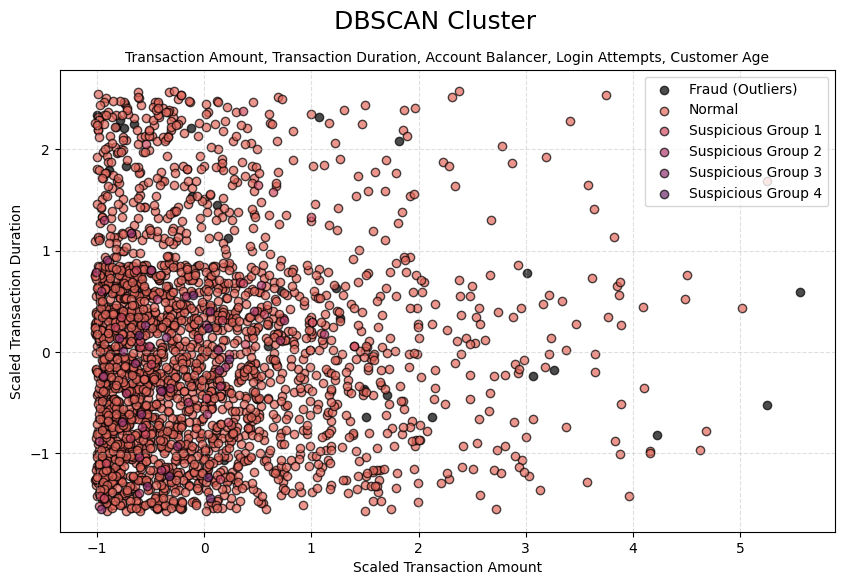

Number of potential frauds detected by DBSCAN: 45


In [8]:
# Map the cluster labels to descriptive names
label_mapping = {
    -1: 'Fraud (Outliers)',  
    0: 'Normal',
    1: 'Suspicious Group 1',
    2: 'Suspicious Group 2',
    3: 'Suspicious Group 3',
    4: 'Suspicious Group 4',
}

features = ['TransactionAmount', 'TransactionDuration', 'AccountBalance', 'LoginAttempts', 'CustomerAge']
X = df[features].copy()

X = X.fillna(X.mean())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

dbscan = DBSCAN(eps=1.5, min_samples=5)  
dbscan.fit(X_scaled)

df['DBSCAN_Cluster'] = dbscan.labels_

df['Cluster_Description'] = df['DBSCAN_Cluster'].map(label_mapping)
potential_frauds = df[df['DBSCAN_Cluster'] == -1]

plt.figure(figsize=(10, 6))
unique_labels = np.unique(dbscan.labels_)

# NOTE: Apply coloring to nodes as its pretty hard to see with the default/auto assigned colors lol.
cluster_colors = sns.color_palette("flare", n_colors=len(unique_labels)) 
colors = []
for i, k in enumerate(unique_labels):
    if k == -1:
        colors.append([0, 0, 0, 1])
    else:
        colors.append(cluster_colors[i % len(cluster_colors)])  

for k, col in zip(unique_labels, colors):
    class_member_mask = (dbscan.labels_ == k)
    xy = X_scaled[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], color=col, edgecolor='k', alpha=0.7, label=label_mapping.get(k, f'Cluster {k}'))

plt.suptitle('DBSCAN Cluster', fontsize=18)
plt.title('Transaction Amount, Transaction Duration, Account Balancer, Login Attempts, Customer Age', fontsize=10)
plt.xlabel("Scaled Transaction Amount")
plt.ylabel("Scaled Transaction Duration")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

print(f"Number of potential frauds detected by DBSCAN: {len(potential_frauds)}")

# Hierarchical Clustering


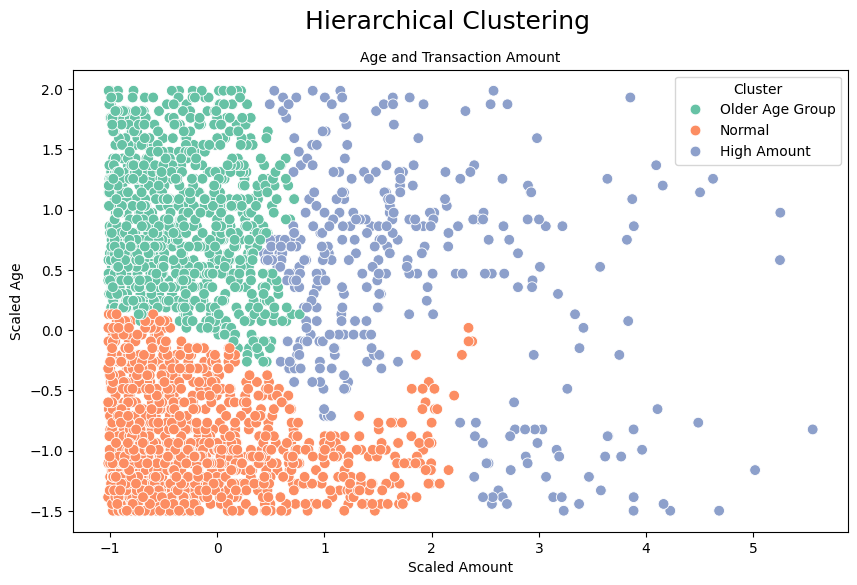

In [13]:
from sklearn.cluster import AgglomerativeClustering

X = df[['TransactionAmount', 'CustomerAge']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

hierarchical = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_scaled)

df['Hierarchical_Cluster'] = hierarchical_labels

cluster_mapping = {0: 'Normal', 1: 'High Amount', 2: 'Older Age Group'}
df['Hierarchical_Cluster'] = df['Hierarchical_Cluster'].map(cluster_mapping)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=df['Hierarchical_Cluster'], palette='Set2', s=60)
plt.suptitle('Hierarchical Clustering', fontsize=18)
plt.title('Age and Transaction Amount', fontsize=10)
plt.xlabel('Scaled Amount')
plt.ylabel('Scaled Age')
plt.legend(title='Cluster')
plt.show()

# Isolation Forest

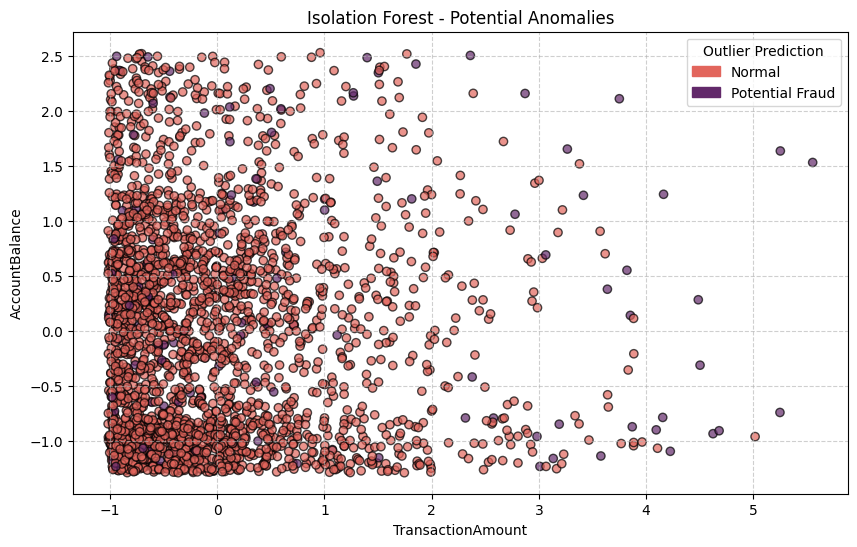

Number of potential frauds detected: 126


In [33]:
import matplotlib.patches as mpatches
from sklearn.ensemble import IsolationForest

outlier_mapping = {1: 'Normal', -1: 'Potential Fraud'}

features = ['TransactionAmount', 'TransactionDuration', 'AccountBalance', 'LoginAttempts', 'CustomerAge']
X = df[features].copy()

X = X.fillna(X.mean())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iso_forest.fit(X_scaled)

df['AnomalyScore'] = iso_forest.decision_function(X_scaled)
df['IsAnomaly'] = iso_forest.predict(X_scaled)  

df['IsFraud'] = df['IsAnomaly']

df['AnomalyLabel'] = df['IsAnomaly'].map(outlier_mapping)

potential_frauds = df[df['IsAnomaly'] == -1]

cmap = plt.get_cmap('flare')
colors = np.array([cmap(0.9) if anomaly == -1 else cmap(0.3) for anomaly in df['IsAnomaly']])

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    X_scaled[:, 0],
    X_scaled[:, 2],
    c=colors, 
    alpha=0.7, 
    edgecolors='k', 
    label='Data Points'
)

normal_patch = mpatches.Patch(color=cmap(0.3), label='Normal')
fraud_patch = mpatches.Patch(color=cmap(0.9), label='Potential Fraud')
plt.legend(handles=[normal_patch, fraud_patch], title='Outlier Prediction')

plt.title('Isolation Forest - Potential Anomalies')
plt.xlabel(features[0])  
plt.ylabel(features[2])  

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print(f"Number of potential frauds detected: {len(potential_frauds)}")

# Logisitc Regression

**NOTE**: Trained based on the results of the Isolation Forest above...

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

features = ['TransactionAmount', 'TransactionDuration', 'AccountBalance', 'LoginAttempts', 'CustomerAge', 'TimeGap']
target = 'IsFraud'

X = df[features]
y = df[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [35]:
# NOTE: Train Model and evaluate performance
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

          -1       0.96      0.67      0.79        33
           1       0.98      1.00      0.99       721

    accuracy                           0.98       754
   macro avg       0.97      0.83      0.89       754
weighted avg       0.98      0.98      0.98       754



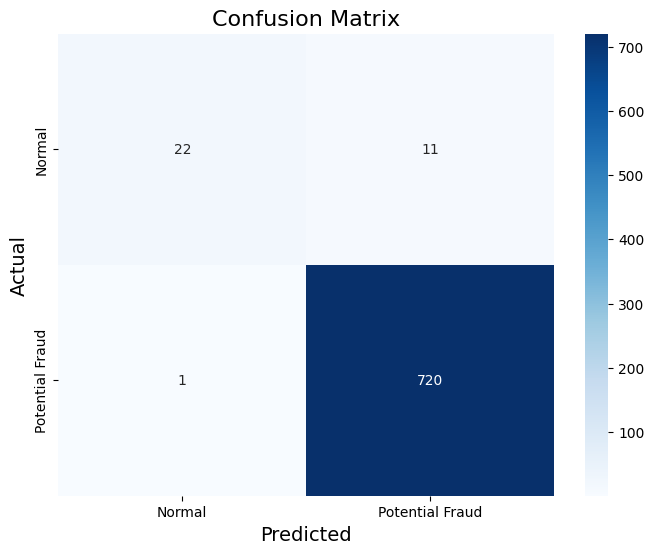

In [40]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Potential Fraud'], yticklabels=['Normal', 'Potential Fraud'])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.show()

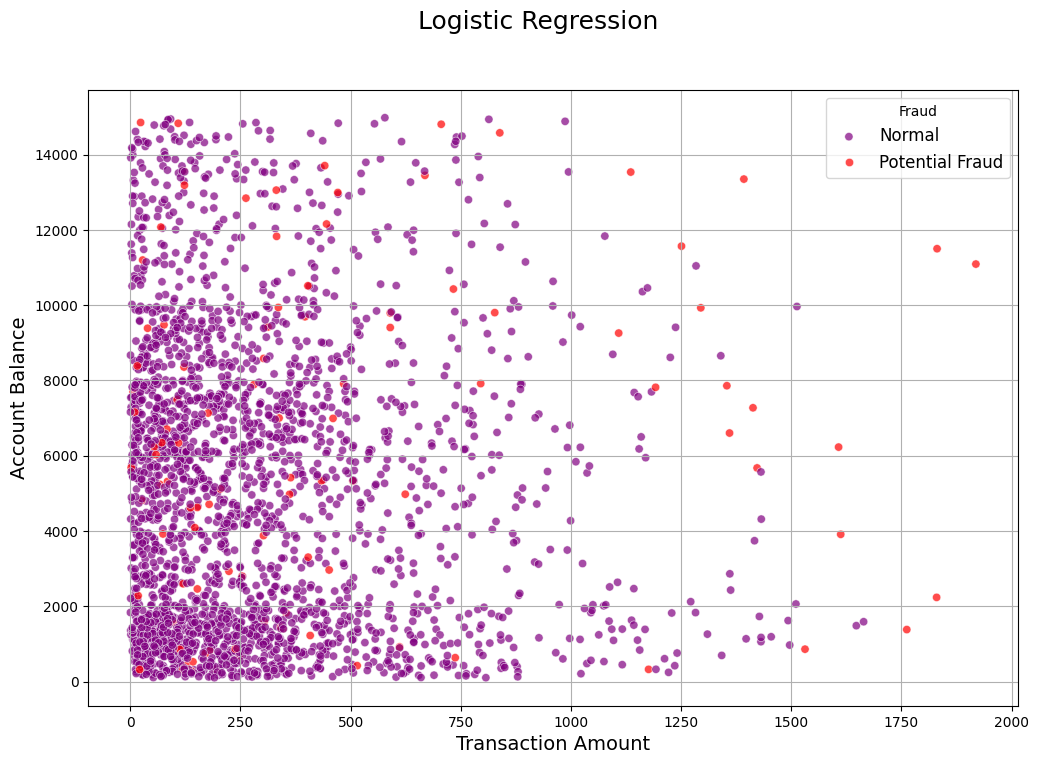

In [39]:
df['LogReg_IsFraud'] = log_reg.predict(X_scaled)

# Scatterplot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=df['TransactionAmount'],
    y=df['AccountBalance'],
    hue=df['LogReg_IsFraud'],
    palette={1: 'purple', -1: 'red'},
    alpha=0.7
)
plt.suptitle('Logistic Regression', fontsize=18)
plt.xlabel('Transaction Amount', fontsize=14)
plt.ylabel('Account Balance', fontsize=14)
plt.legend(title='Fraud', labels=['Normal', 'Potential Fraud'], fontsize=12)
plt.grid(True)
plt.show()